# Cahn-Hilliard with Primtive and Legendre Bases

This example uses a Cahn-Hilliard model to compare two different bases representations to discretize the microstructure. One basis representaion uses the primitive (or hat) basis and the other uses Legendre polynomials. The example includes the background theory about using Legendre polynomials as a basis in MKS. The MKS with two different bases are compared with the standard spectral solution for the Cahn-Hilliard solution at both the calibration domain size and a scaled domain size. 

### Cahn-Hilliard Equation

The Cahn-Hilliard equation is used to simulate microstructure evolution during spinodial decomposition and has the following form,

$$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

where $\phi$ is a conserved ordered parameter and $\sqrt{\gamma}$ represents the width of the interface. In this example, the Cahn-Hilliard equation is solved using a semi-implicit spectral scheme with periodic boundary conditions, see  [Chang and Rutenberg](http://dx.doi.org/10.1103/PhysRevE.72.055701) for more details.

### Basis Functions for the Microstructure Function and Influence Function

In this example, we will explore the differences when using the
Legendre polynomials as the basis function compared to the primitive
(or hat) basis for the microstructure function and the influence coefficients.

For more information about both of these basis please see the [theory section](THEORY.html).

In [17]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

import pymks

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Modeling with MKS

### Generating Calibration Datasets

Because the microstructure is a continuous field that can have a range of values and changes over time, the first order influence coefficients cannot be calibrated with delta microstructures. Instead, a large number of simulations with random initial conditions will be used to calibrate the first order influence coefficients using linear regression. Let's show how this is done.

The function `make_cahnHilliard` from `pymks.datasets` provides a nice interface to generate calibration datasets for the influence coefficients. The function `make_cahnHilliard` requires the number of calibration samples, given by `n_samples`, and the size and shape of the domain, given by `size`.

In [18]:
import pymks
from pymks.datasets import make_cahn_hilliard


length = 41
n_samples = 400
dt = 1e-2
np.random.seed(101)
size=(length, length)
X, y = make_cahn_hilliard(n_samples=n_samples, size=size, dt=dt)


The function `make_cahnHilliard` has generated `n_samples` number of random microstructures, `X`, and returned the same microstructures after they have evolved for one time step, given by `y`. Let's take a look at one of them.

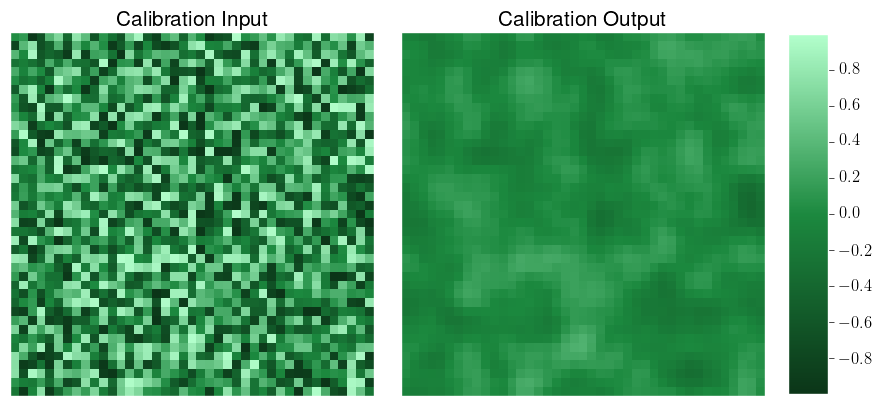

In [19]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

from pymks.tools import draw_concentrations


draw_concentrations((X[0], y[0]),('Calibration Input', 'Calibration Output'))


### Calibrate Influence Coefficients
 
In this example, we compare the difference between using the primitive (or hat) basis and the Legendre polynomial basis to represent the microstructure function. As mentioned above, the microstructures (concentration fields) are not discrete phases. This leaves the number of local states in local state space `n_states` as a free hyperparameter. In the next section, we look to see what a practical number of local states for bases would be. 
 
### Optimizing the Number of Local States
 
Below, we compare the difference in performance, as we vary the local state, when we choose the primitive basis and the Legendre polynomial basis.

The `(X, y)` sample data is split into training and test data. The code then optimizes `n_states` between `2` and `11` and the two `basis` with the `parameters_to_tune` variable. The `GridSearchCV` takes an `MKSLocalizationModel` instance, a `scoring` function (figure of merit) and the `parameters_to_tune` and then finds the optimal parameters with a grid search.

In [20]:
from pymks.bases import PrimitiveBasis
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
mse = metrics.mean_squared_error
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel
from sklearn.cross_validation import train_test_split


train_split_shape = (X.shape[0],) + (np.prod(X.shape[1:]),)

X_train, X_test, y_train, y_test = train_test_split(X.reshape(train_split_shape),
                                                    y.reshape(train_split_shape),
                                                    test_size=0.5, random_state=3)

prim_basis = PrimitiveBasis(2, [-1, 1])
leg_basis = LegendreBasis(2, [-1, 1])

params_to_tune = {'n_states': np.arange(2, 11),
                 'basis': [prim_basis, leg_basis]}
Model = MKSLocalizationModel(prim_basis)
scoring = metrics.make_scorer(lambda a, b: -mse(a, b))
fit_params = {'size': size}
gs = GridSearchCV(Model, params_to_tune, cv=5,
                  fit_params=fit_params, n_jobs=3).fit(X_train, y_train)


The optimal parameters are the `LegendreBasis` with only 4 local states. More terms don't improve the R-squared value.

In [21]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

print(gs.best_estimator_)
print(gs.score(X_test, y_test))


MKSLocalizationModel(basis=<pymks.bases.legendre.LegendreBasis object at 0x7f086b288a58>,
           lstsq_rcond=2.2204460492503131e-12, n_jobs=None, n_states=4)
1.0


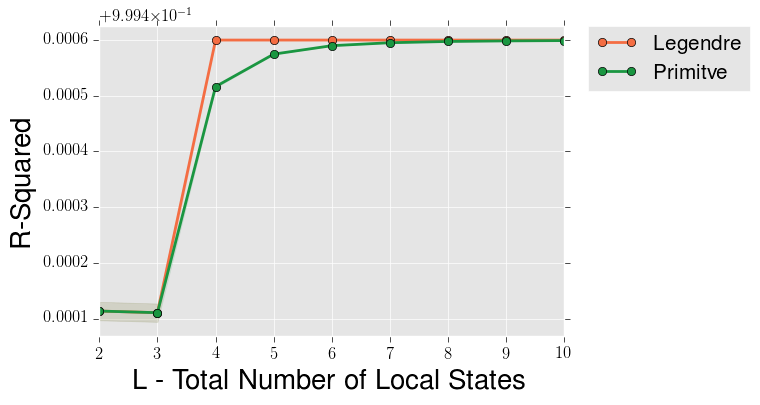

In [22]:
from pymks.tools import draw_gridscores


lgs = [x for x in gs.grid_scores_ \
       if type(x.parameters['basis']) is type(leg_basis)]
pgs = [x for x in gs.grid_scores_ \
       if type(x.parameters['basis']) is type(prim_basis)]

draw_gridscores([lgs, pgs], 'n_states', data_labels=['Legendre', 'Primitve'],
                colors=['#f46d43', '#1a9641'], score_label='R-Squared', 
                param_label = 'L - Total Number of Local States')


As you can see the `LegendreBasis` converges faster than the `PrimitiveBasis`. In order to further compare performance between the two models, lets select 4 local states for both bases.

### Comparing the Bases for `n_states=4`

In [23]:
prim_basis = PrimitiveBasis(n_states=4, domain=[-1, 1])
prim_model = MKSLocalizationModel(basis=prim_basis)
prim_model.fit(X, y)

leg_basis = LegendreBasis(4, [-1, 1])
leg_model = MKSLocalizationModel(basis=leg_basis)
leg_model.fit(X, y)


Now let's look at the influence coefficients for both bases.

First, the `PrimitiveBasis` influence coefficients:

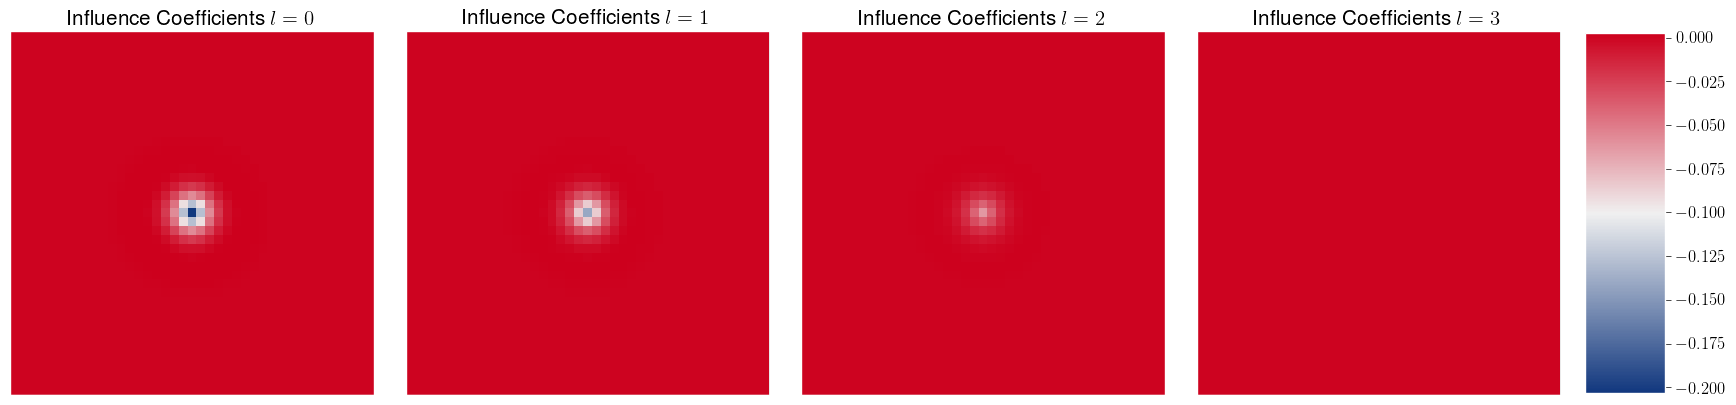

In [24]:
from pymks.tools import draw_coeff

draw_coeff(prim_model.coef_)


Now, the `LegendreBasis` influence coefficients:

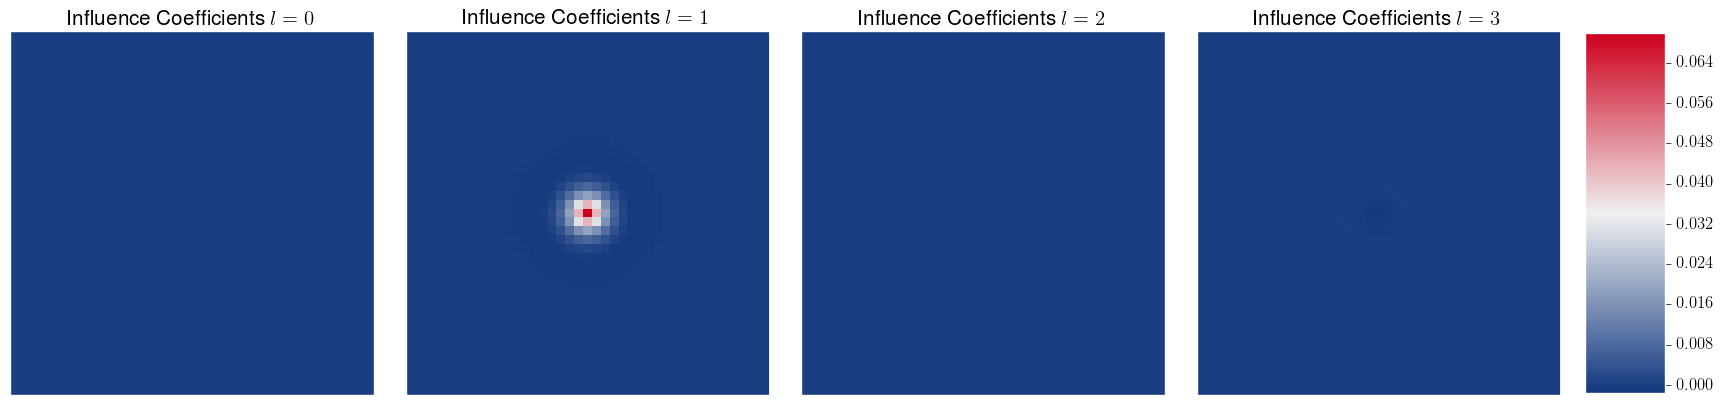

In [25]:
draw_coeff(leg_model.coef_)


Now, let's do some simulations with both sets of coefficients and compare the results.

### Predict Microstructure Evolution

In order to compare the difference between the two bases, we need to have the Cahn-Hilliard simulation and the two MKS models start with the same initial concentration `phi0` and evolve in time. In order to do the Cahn-Hilliard simulation, we need an instance of the class `CahnHilliardSimulation`.

In [26]:
from pymks.datasets.cahn_hilliard_simulation import CahnHilliardSimulation


np.random.seed(66)
phi0 = np.random.normal(0, 1e-9, ((1,) + size))
ch_sim = CahnHilliardSimulation(dt=dt)
phi_sim = phi0.copy()
phi_prim = phi0.copy()
phi_legendre = phi0.copy()


Let's look at the inital concentration field.

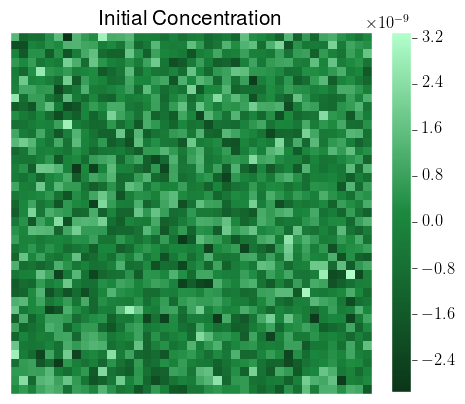

In [27]:
draw_concentrations([phi0[0]], ['Initial Concentration'])


In order to move forward in time, we need to feed the concentration back into the Cahn-Hilliard simulation and the MKS models.

In [28]:
time_steps = 50

for steps in range(time_steps):
    ch_sim.run(phi_sim)
    phi_sim = ch_sim.response
    phi_prim = prim_model.predict(phi_prim)
    phi_legendre = leg_model.predict(phi_legendre)
    

Let's take a look at the concentration fields.

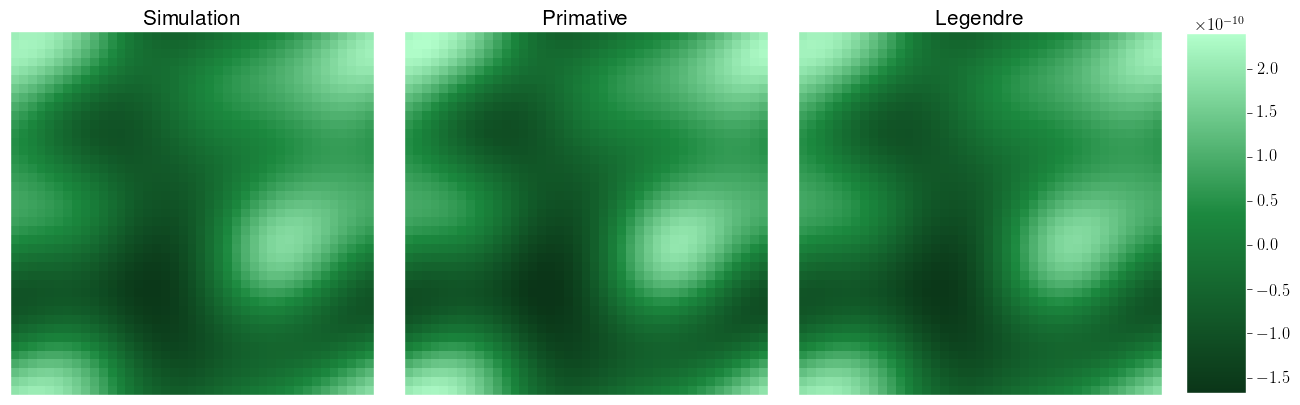

In [29]:
from pymks.tools import draw_concentrations


draw_concentrations((phi_sim[0], phi_prim[0], phi_legendre[0]),
                    ('Simulation', 'Primative', 'Legendre'))


By just looking at the three microstructures is it difficult to see any differences. Below, we plot the difference between the two MKS models and the simulation.

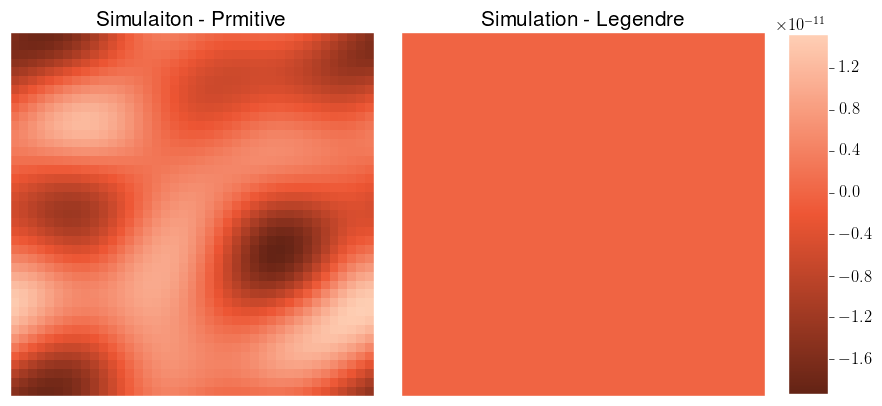

Primative mse = 5.27939945401e-23
Legendre mse = 7.65184826764e-28


In [30]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

from sklearn import metrics
from pymks.tools import draw_differences


mse = metrics.mean_squared_error
draw_differences([(phi_sim[0] - phi_prim[0]), (phi_sim[0] - phi_legendre[0])],
                 ['Simulaiton - Prmitive', 'Simulation - Legendre'])

print('Primative mse =', mse(phi_sim[0], phi_prim[0]))
print('Legendre mse =', mse(phi_sim[0], phi_legendre[0]))


The `LegendreBasis` basis clearly outperforms the `PrimitiveBasis` for the same value of `n_states`.

## Resizing the Coefficients to use on Larger Systems 

Below we compare the bases after the coefficients are resized.

In [31]:
big_length = 3 * length
big_size = (big_length, big_length)
prim_model.resize_coeff(big_size)
leg_model.resize_coeff(big_size)

phi0 = np.random.normal(0, 1e-9, (1,) + big_size)
phi_sim = phi0.copy()
phi_prim = phi0.copy()
phi_legendre = phi0.copy()


Let's take a look at the initial large concentration field.

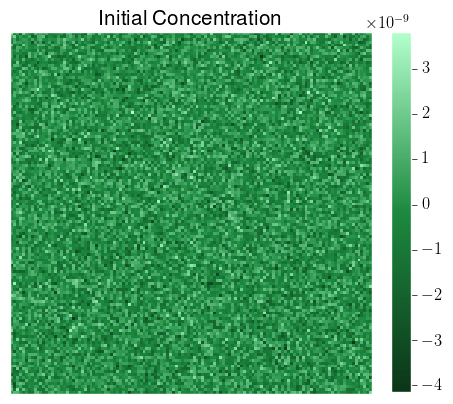

In [32]:
draw_concentrations([phi0[0]], ['Initial Concentration'])


Let's look at the resized coefficients.

First, the influence coefficients from the `PrimitiveBasis`.

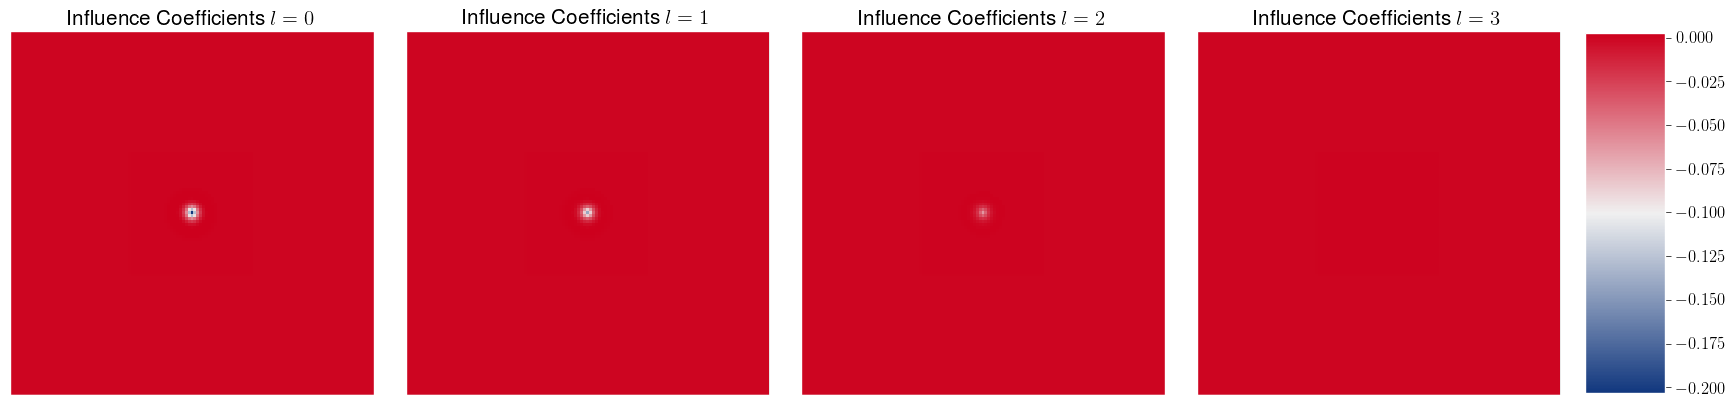

In [33]:
draw_coeff(prim_model.coef_)


Now, the influence coefficients from the `LegendreBases`.

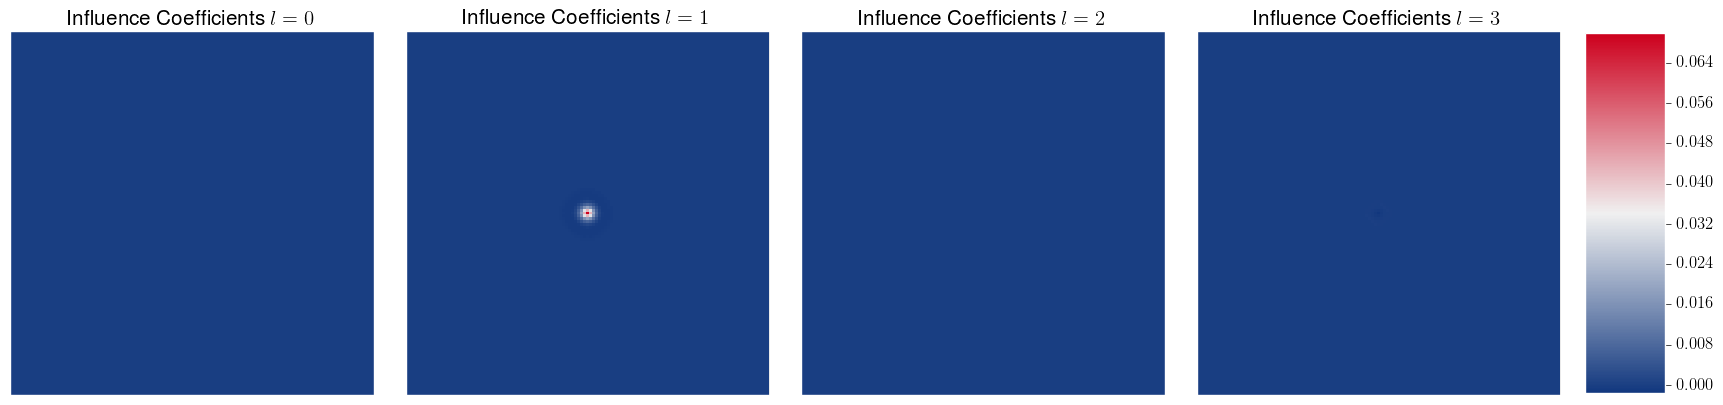

In [34]:
draw_coeff(leg_model.coef_)


Once again, we are going to march forward in time by feeding the concentration fields back into the Cahn-Hilliard simulation and the MKS models. 

In [35]:
for steps in range(time_steps):
    ch_sim.run(phi_sim)
    phi_sim = ch_sim.response
    phi_prim = prim_model.predict(phi_prim)
    phi_legendre = leg_model.predict(phi_legendre)
    

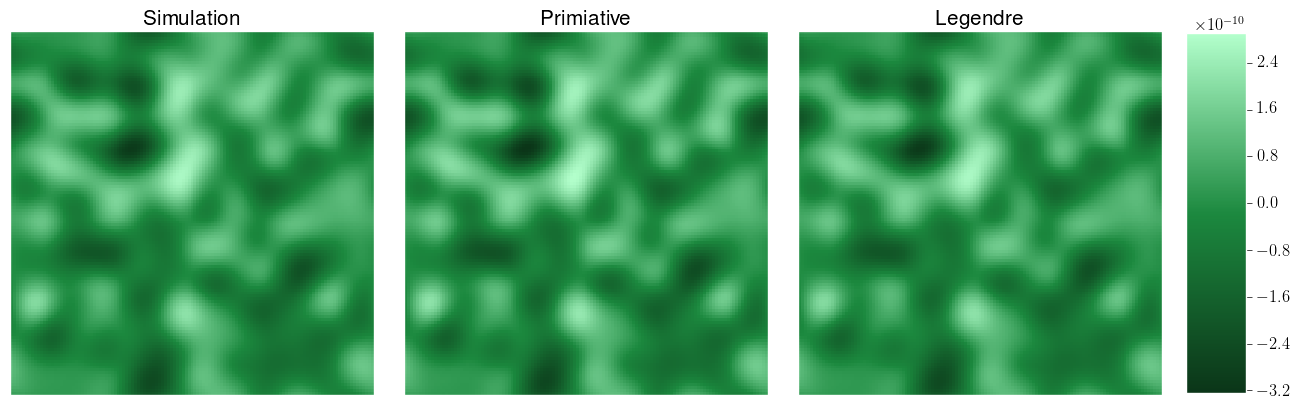

In [36]:
draw_concentrations((phi_sim[0], phi_prim[0], phi_legendre[0]), ('Simulation', 'Primiative', 'Legendre'))


Both MKS models seem to predict the concentration faily well. However, the Legendre polynomial basis looks to be better. Again, let's look at the difference between the simulation and the MKS models.

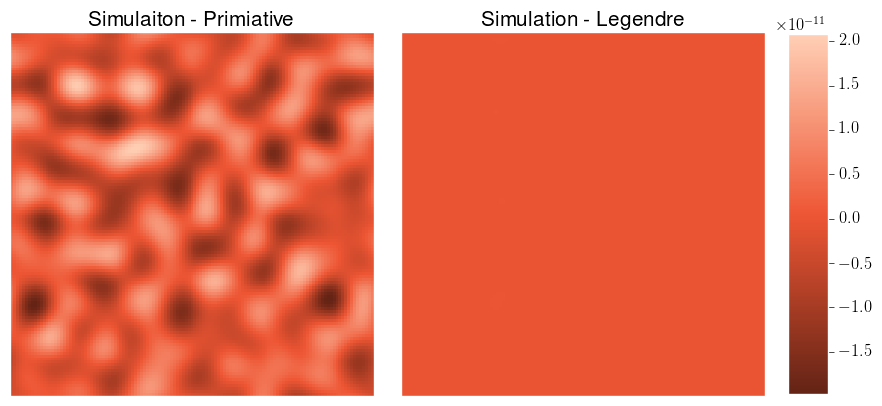

Primative mse = 4.41565263124e-23
Legendre mse = 7.97143930325e-28


In [37]:
#PYTEST_VALIDATE_IGNORE_OUTPUT

draw_differences([(phi_sim[0] - phi_prim[0]), (phi_sim[0] - phi_legendre[0])], 
                 ['Simulaiton - Primiative','Simulation - Legendre'])

print('Primative mse =', mse(phi_sim[0], phi_prim[0]))
print('Legendre mse =', mse(phi_sim[0], phi_legendre[0]))


With the resized influence coefficients, the `LegendreBasis` outperforms the `PrimitiveBasis` for the same value of `n_states`. The value of `n_states` does not necessarily guarantee a fair comparison between the two basis in terms of floating point calculations and memory used.